# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import scipy.stats as stats
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt

import random
import scipy.stats as stats
import numpy as np
import matplotlib.gridspec as gridspec
import tensorflow as tf
from sklearn.utils import shuffle
import time
import os

import helper as aux
import cnn_layers as cnnl
import models

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = '/input/train.p'
validation_file= '/input/valid.p'
testing_file = '/input/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(pd.Series(y_test).unique())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

25 Randomly Sampled Images of the Training Set:


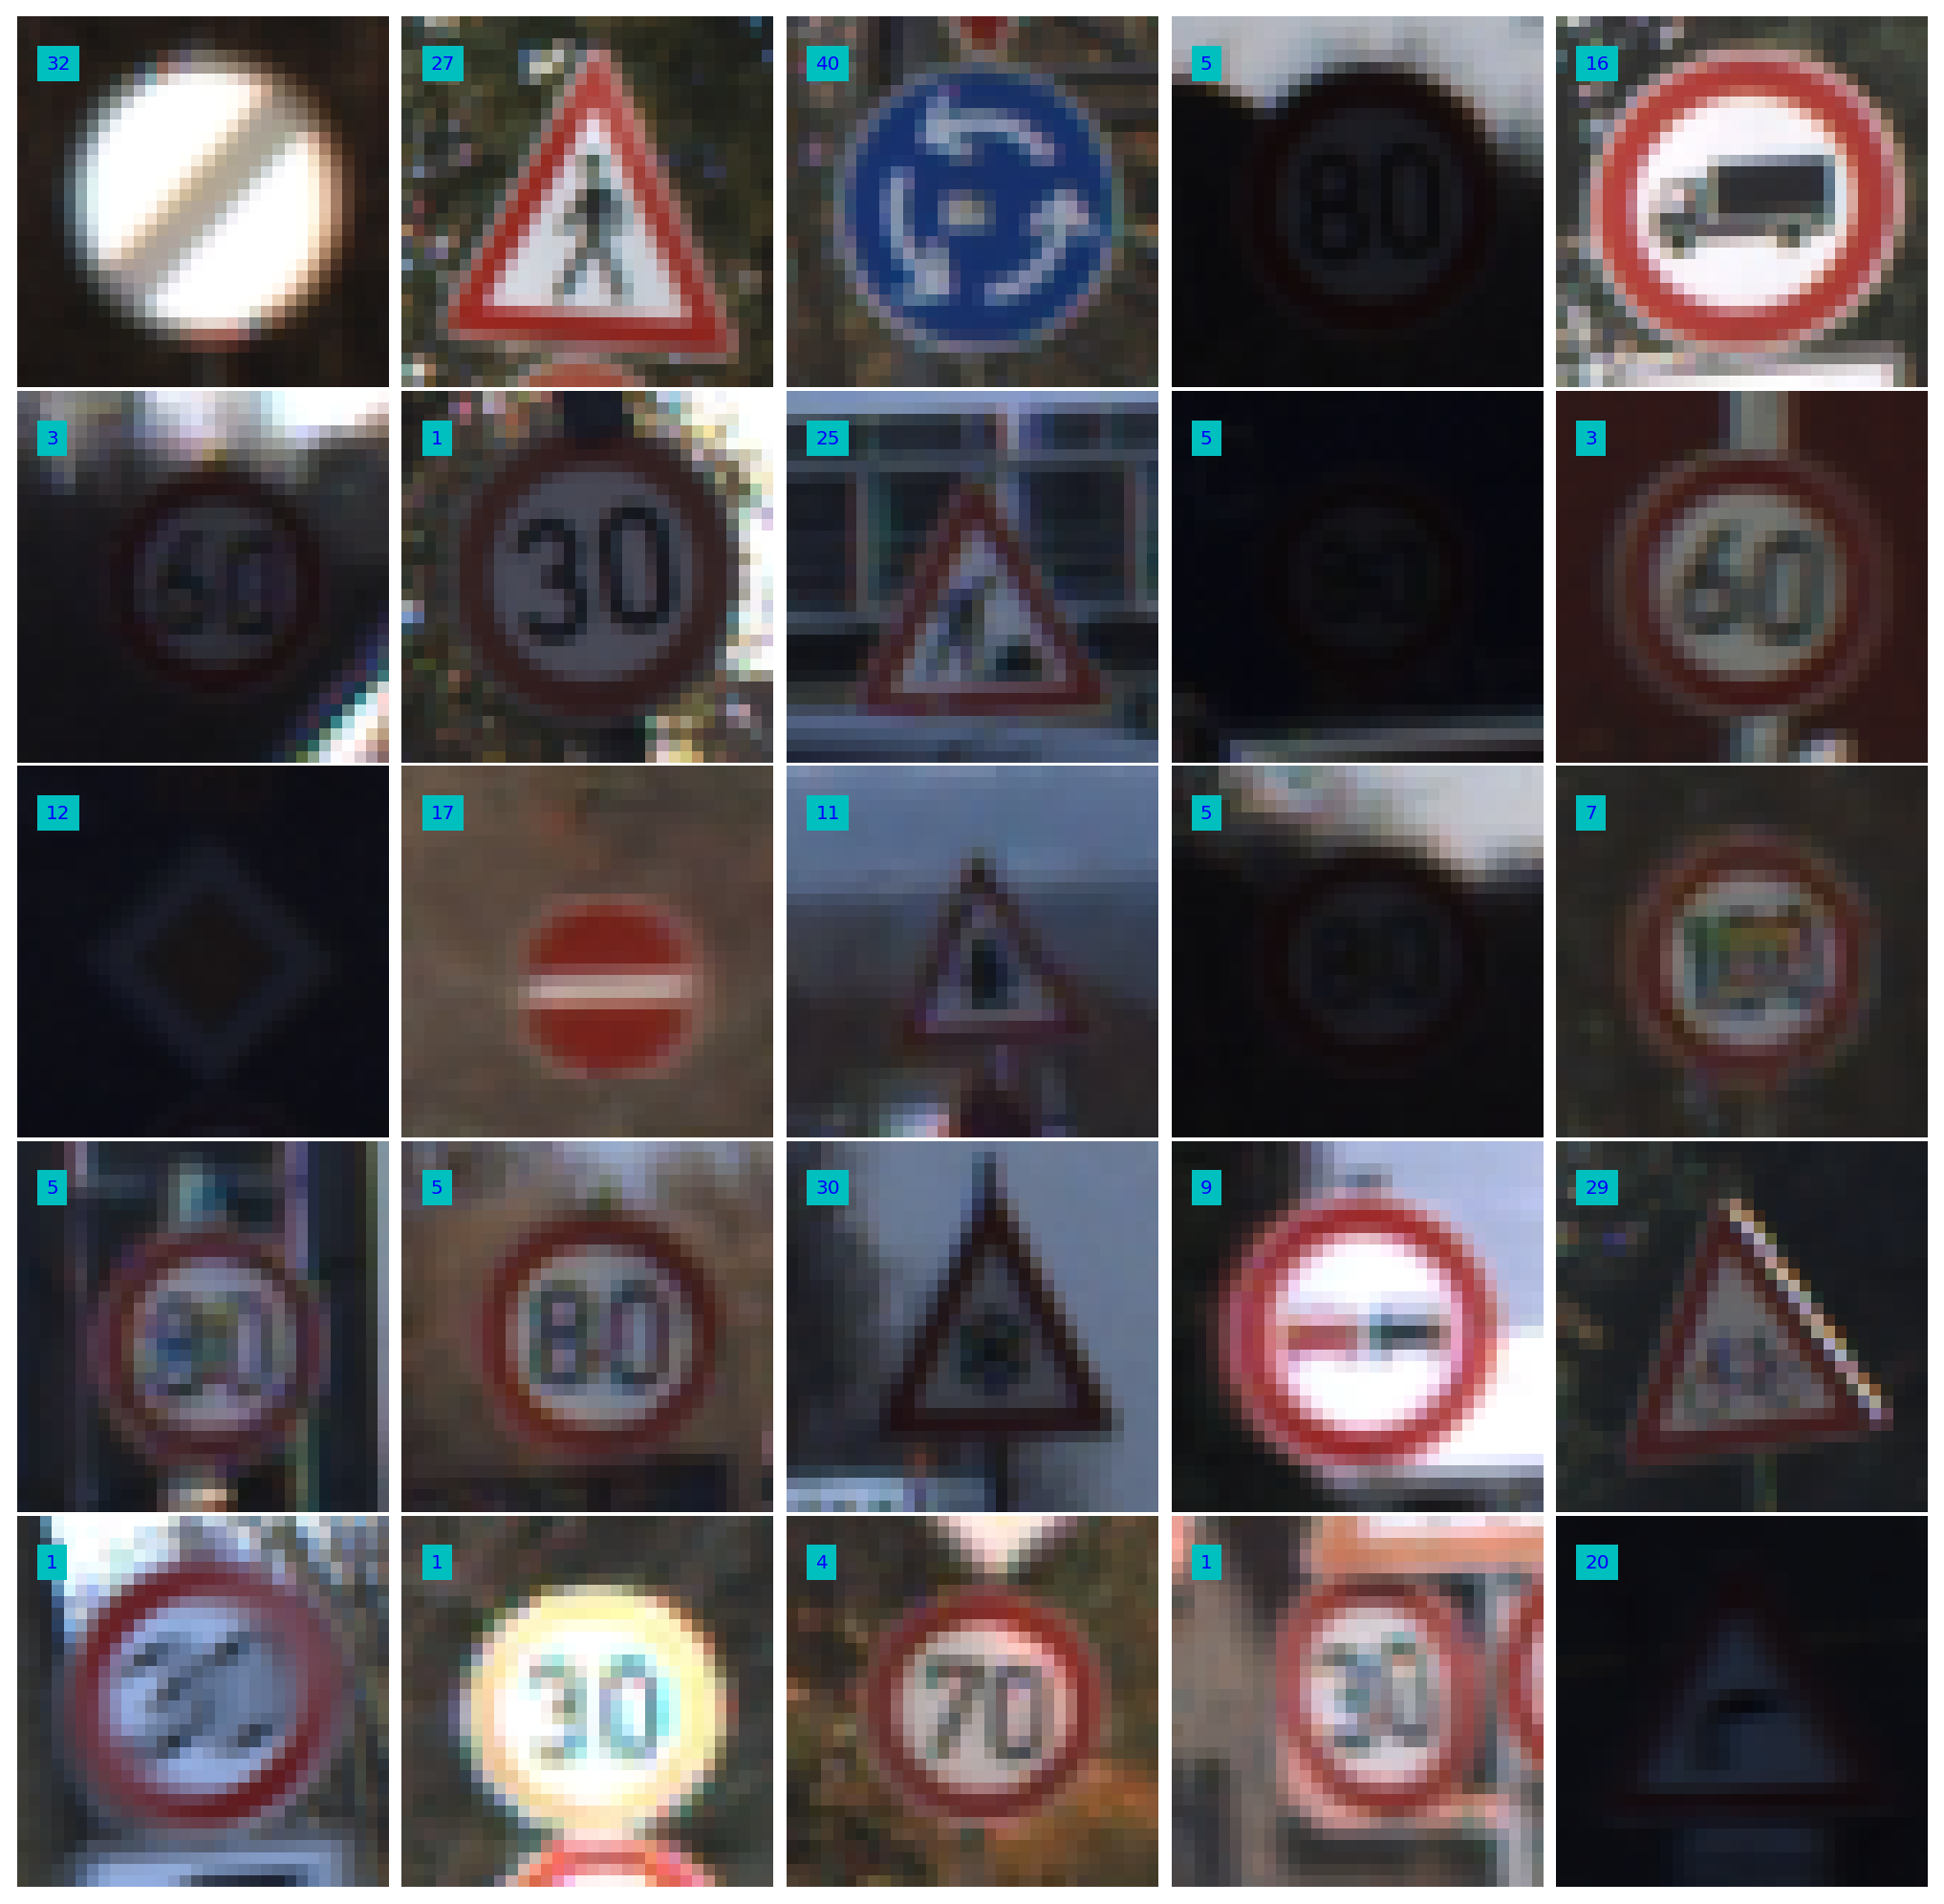

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
index = random.randint(0, len(X_train))
#index = 0
image = X_train[index]


print('25 Randomly Sampled Images of the Training Set:')
aux.plot_samples(5, 5, X_train, y_train)

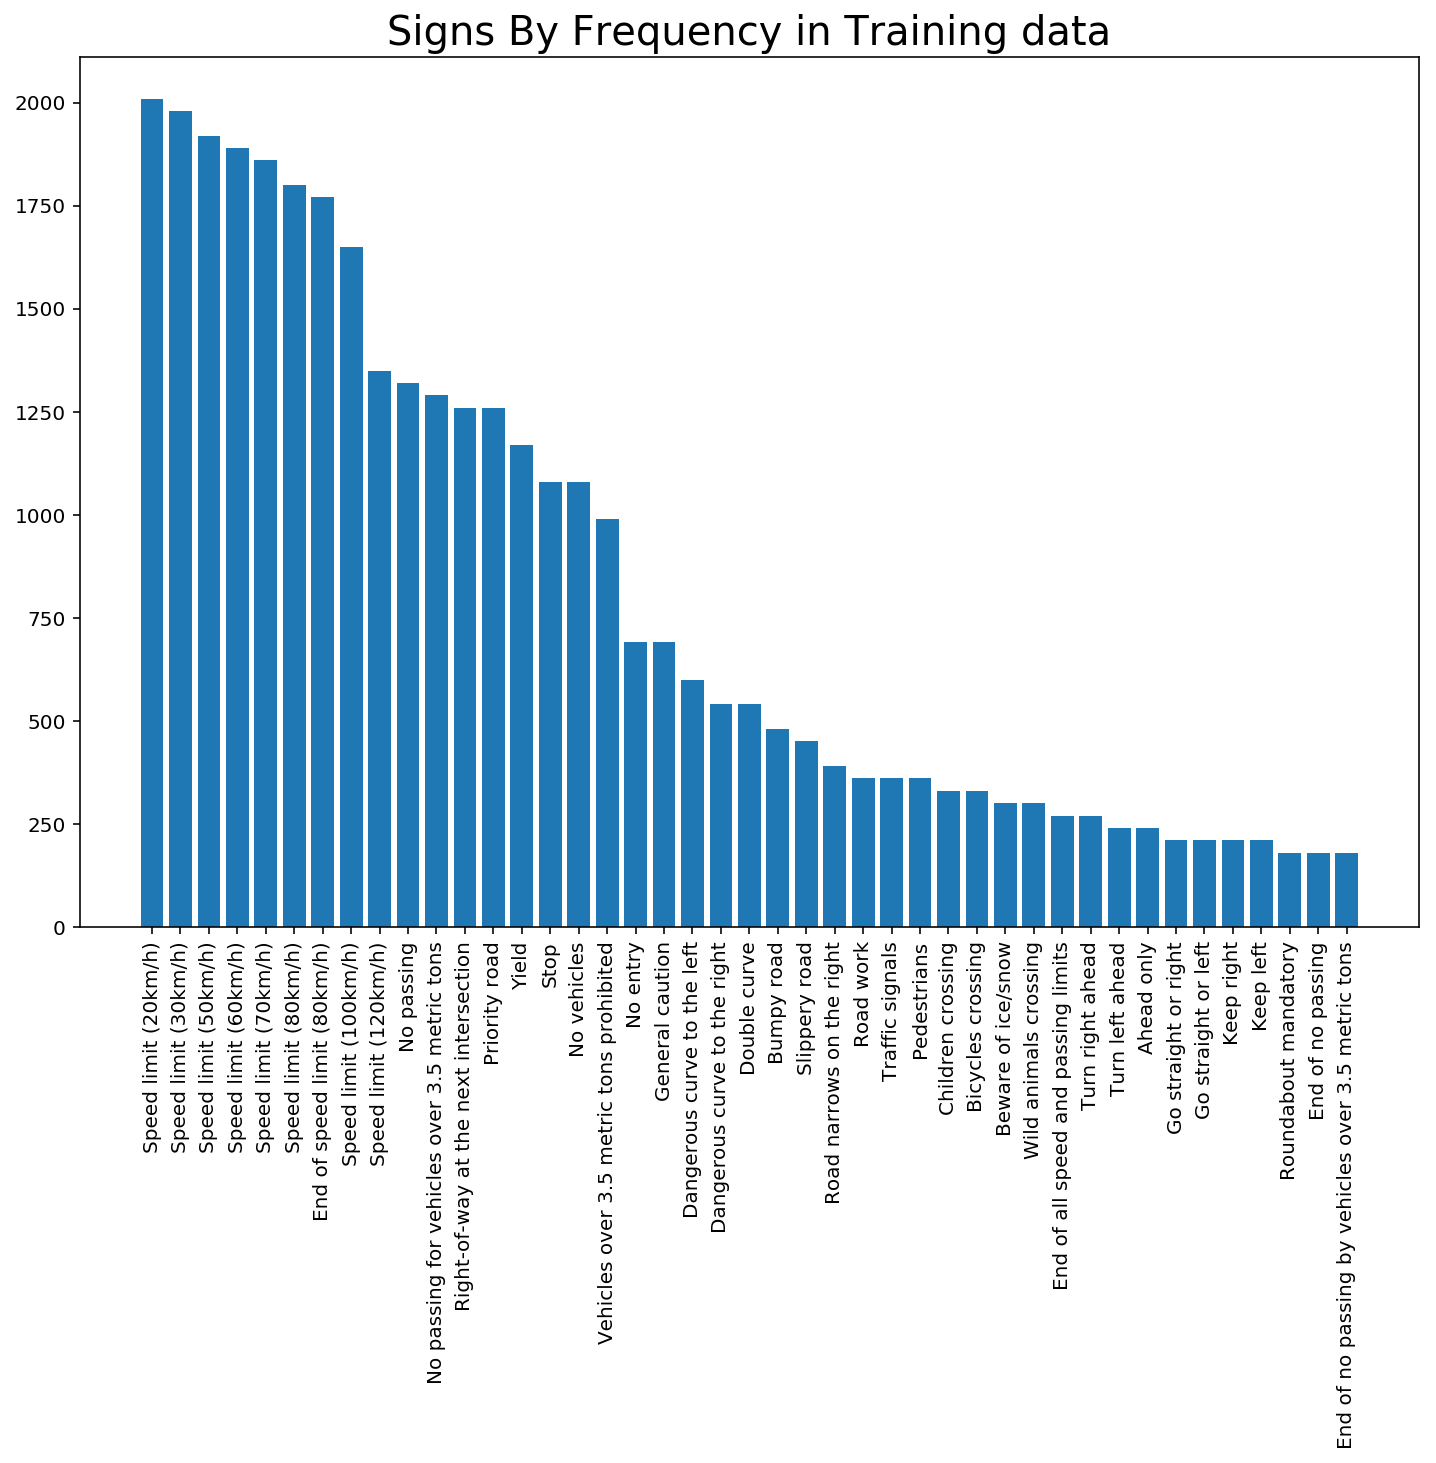

In [5]:
#Chart inspired by ideas of Vivek Yadav - student of earlier class:

freq_by_sign = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
freq_bs_sorted = sorted(freq_by_sign, key=lambda x: x[1])
sign_names = pd.read_csv('signnames.csv')
sign_names['Frequency'] = pd.Series(np.asarray(freq_bs_sorted).T[1], index=np.asarray(freq_bs_sorted).T[0])
sign_names_sorted = sign_names.sort_values(['Frequency'],ascending=[0]).reset_index()
sign_names_sorted = sign_names_sorted.drop('index', 1)

plt.figure(figsize=(12,8))
plt.title('Signs By Frequency in Training data', fontsize=20)
plt.xticks(range(sign_names.shape[0]), sign_names['SignName'], rotation='vertical')
plt.bar(range(sign_names.shape[0]),height=sign_names_sorted["Frequency"])
print()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

### Preprocessing

Here are some of tested image transformations. Grayscacling omitted as color information may be relevant for better classification, as will be shown later. One of transformations (aux.normalize) is my own implementation that I created before discovering the vast variety of available possibilities with OpenCV. Turn out it is almost identical to histogram equalization, though at some extreme cases of maximum contrast the latter performs better.

Numerous training tests proved histogram equalization through all three channels works best.

Index: 4753
Sign category: Bumpy road


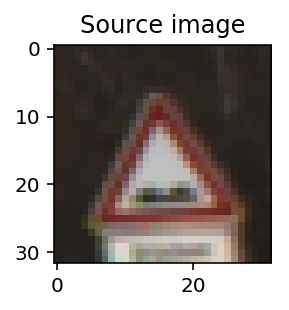

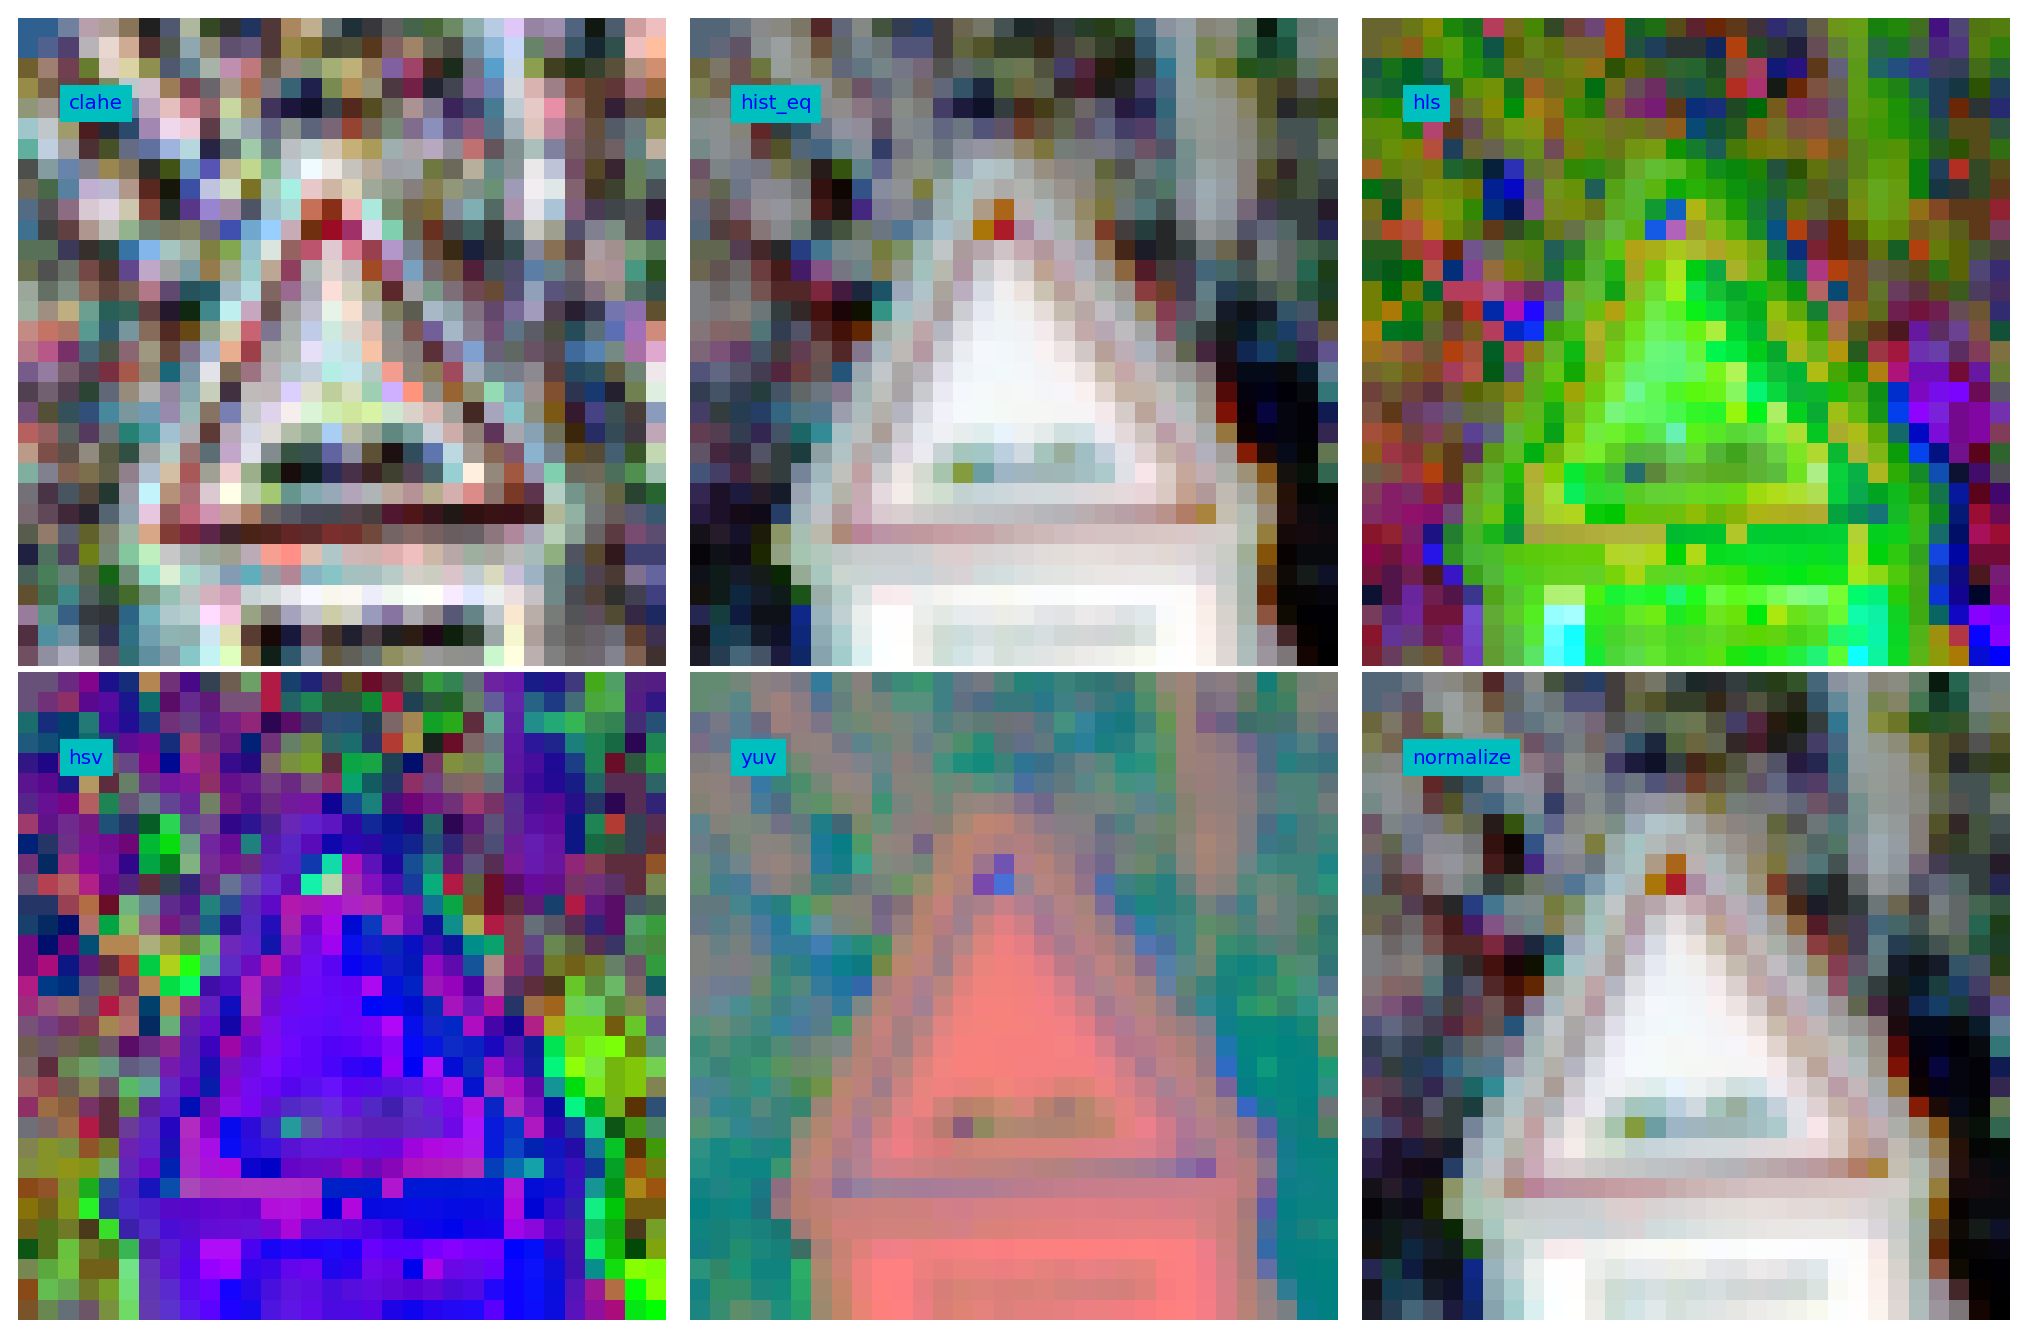

In [6]:
### Preprocess the data here. Preprocessing steps could include
# normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
index = random.randint(0, len(X_train))

source_img = X_train[index]
plt.figure(figsize=(2,2))
plt.imshow(source_img)
plt.title('Source image')
print('Index: {}'.format(index))
print('Sign category: {}'.format(sign_names['SignName'][y_train[index]]))

normalization_funcs = [aux.clahe,  
                       aux.hist_eq, 
                       aux.hls, 
                       aux.hsv,
                       aux.yuv,
                       aux.normalize]

pre_processed_imges = []
labels = []

for func in normalization_funcs:
    pre_processed_imges.append(func(source_img))
    labels.append(func.__name__) #y_train[index]) #just to have something to plug

aux.plot_samples(3,2,pre_processed_imges, labels, randomize=False)


### Augmentation

Training and validation sets have been inflated 6 times by adding 5 images with random affine transformations and brightness variations per each sample. This preserves relative frequencies among classes. The existing relative frequencies may be relevant for better performance as it probably reflects the real life relative frequencies. At least, test set has the same frequency distribution as the training one. This would probably improve performance deriving the inclination for the network to pick the more frequent option in case of uncertainty.
Augmentation code itself inspired by Vivek Yadav, though brightness is my own (keeps values within the 0-255 range)

In [7]:
angle = 15 #the range for random angle 
shear = 5 #the range for random shear 
trans = 5 #the range for random trans
augment_brightness = True

#images being added this number of pixels before transform and then
#cropped back to the original size (32x32)
margin_delta = 3 

#Dataset for real training on the GPU instance had 5 additional images
extra_img_count = 5

args = [angle, shear, trans, augment_brightness, margin_delta]

print('Augmenting training data..')
X_train, y_train = aux.augment(X_train, y_train, augs_count=extra_img_count, aug_args=args)
print('Training data augmentation complete.')
print()
print('Augmenting validation data..')
X_valid, y_valid = aux.augment(X_valid, y_valid, augs_count=extra_img_count, aug_args=args)
print('Validation data augmentation complete.')

Augmenting training data..
2000 of 34799 items processed
4000 of 34799 items processed
6000 of 34799 items processed
8000 of 34799 items processed
10000 of 34799 items processed
12000 of 34799 items processed
14000 of 34799 items processed
16000 of 34799 items processed
18000 of 34799 items processed
20000 of 34799 items processed
22000 of 34799 items processed
24000 of 34799 items processed
26000 of 34799 items processed
28000 of 34799 items processed
30000 of 34799 items processed
32000 of 34799 items processed
34000 of 34799 items processed
Training data augmentation complete.

Augmenting validation data..
2000 of 4410 items processed
4000 of 4410 items processed
Validation data augmentation complete.


#### Normalizing augmented data and saving to disk.

In [8]:
### Parameters for normalization

channel_combinations = [[0,1,2]]

normalize_args = [[True, 0.8, True],[True, 0.8, False]]
bw_args = [[False], [True]]
transform_funcs = [aux.hist_eq]
file_names = []

In [9]:
# Gets the name of a given variable
def namestr(obj):
    result = [name for name in globals() if globals()[name] is obj]
    return result[0]

data_segments = [[X_train, y_train],[X_valid, y_valid],[X_test, y_test]]

# Histogram equalization picked for best performance.
normalize_func = aux.hist_eq

#this remains from testing normalization on various channel combinations
for ch_combination in channel_combinations:
    
    func_name = normalize_func.__name__
    args_string = '_'.join(str(x).replace('.','') for x in ch_combination)

    seg_names = []

    for data_seg in data_segments:
        seg_name = namestr(data_seg[0]).replace('X_','')
        file_name = '{}/{}_{}_{}.p'.format('processed', seg_name, func_name, args_string)

        aux.process_and_save(normalize_func, data_seg[0], data_seg[1], file_name, args=ch_combination)

        seg_names.append(file_name)

    file_names.append(seg_names)
    
# Multiple functions were tested, hence the array is 2D.
# As Histogram equalization picked as the winneer, only one record exist though
for file_name in file_names[0]:
    print(file_name)


processed/train_hist_eq_0_1_2.p
processed/valid_hist_eq_0_1_2.p
processed/test_hist_eq_0_1_2.p


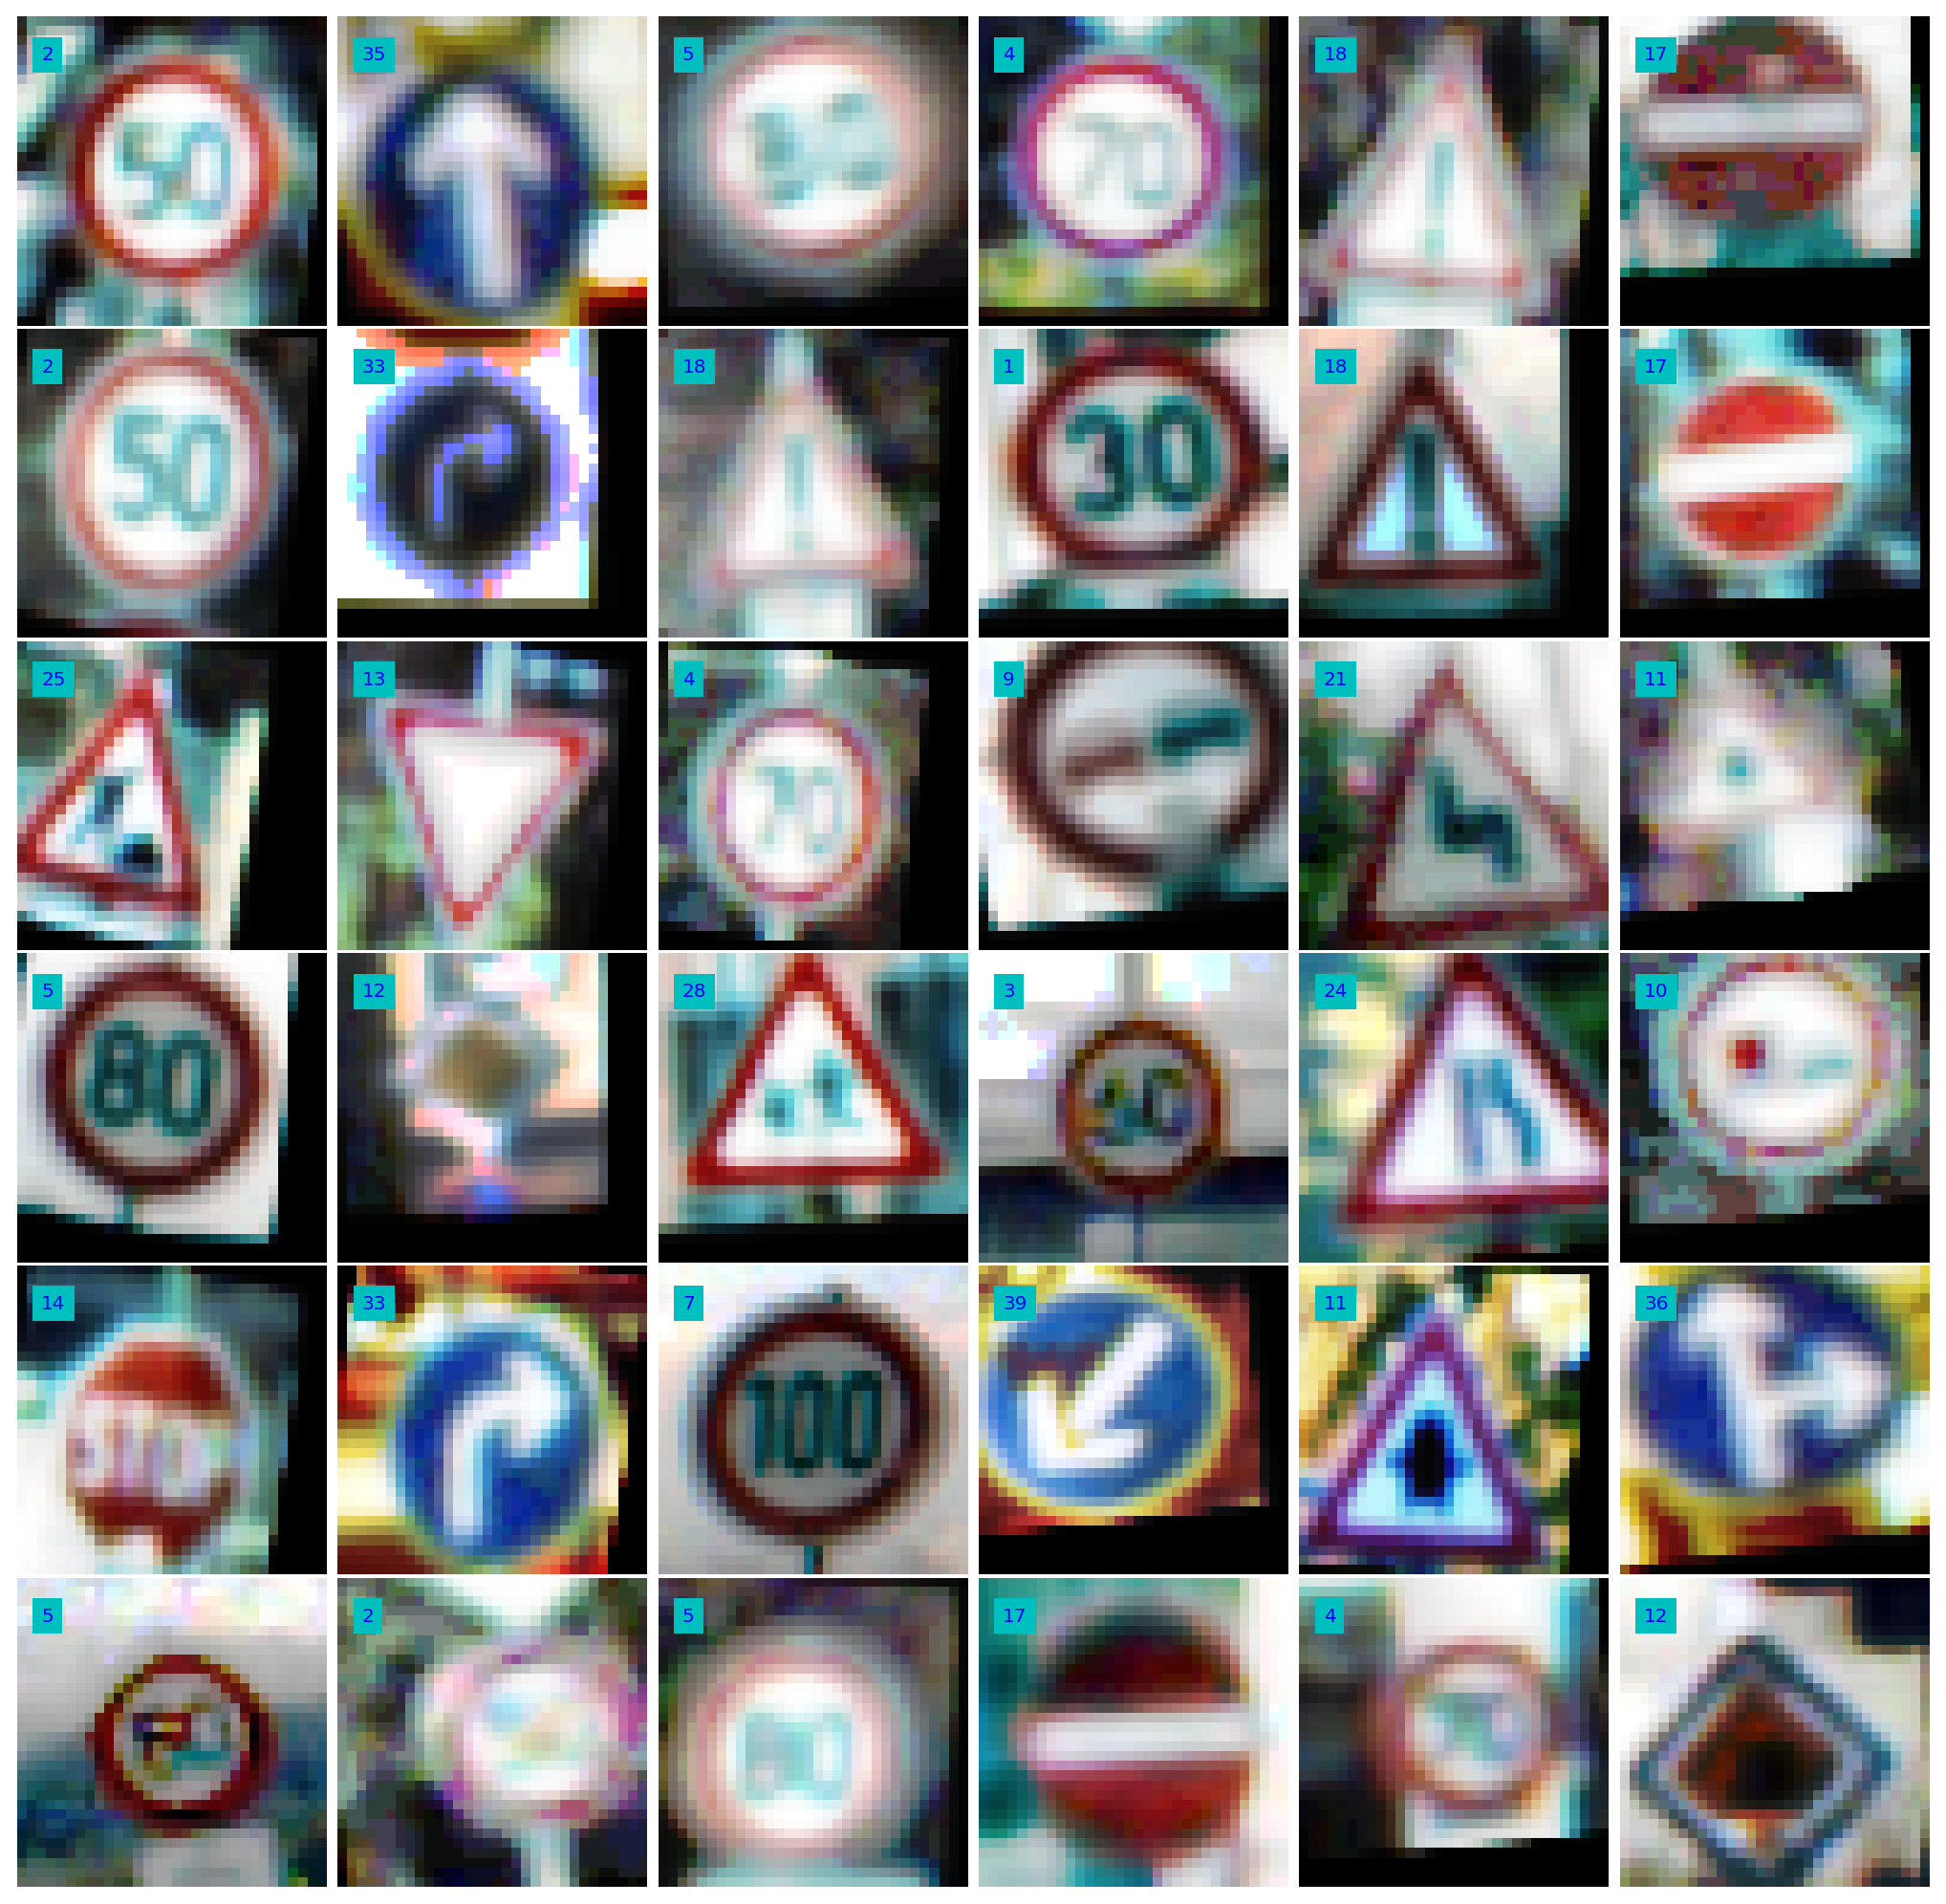

In [10]:
training_file = file_names[0][0]

with open(training_file, mode='rb') as f:
    train_processed = pickle.load(f)

X_train_proc, y_train_proc = np.array(train_processed[0]), np.array(train_processed[1])

aux.plot_samples(6,6,X_train_proc, y_train_proc)
X_train_proc = None
y_train_proc = None

### Model Architecture

Numerous architectures of variable depth and breadth have been tested, including fancy implementations with merging separate convolutional layers into one flattened.

Turns out going deeper than 3 layers of convolution makes no sense with such a tiny dimentions of the input images.

The final picked archtecture is:

CNN with 5 hidden layers - 3 convolutional followed by 2 fully connected layers of 2048 and 1024 nodes respectively.
5x5 kernel with stride on 1 applied in the first convolutional layer,
3x3 kernels with strides of 1 at 2nd and 3rd.
Max-pooling applied to all 3 convolutional layers.
Dropout applied to all 5 hidden layers

Implementation allows to retrieve layers' weights for further L2-regularization and model name for saving purposes.

The model defined as `traffic_net_v2_full_dropout` in `models.py`

In [11]:
def traffic_net_v2_full_dropout(x, keep_probability, activation='relu'):
    kernel_size = [5, 5]
    kernel_strides = [1, 1]
    pool_k_size = [2, 2]
    pool_strides = [2, 2]
    k_args = [kernel_size, kernel_strides, 'SAME']
    p_args = [pool_k_size, pool_strides, 'SAME']

    k2_args = [[3, 3], [1, 1], 'VALID']
    k3_args = [[3, 3], [1, 1], 'VALID']

    cv1, cvw1 = cnnl.conv2d_layer(x_tensor=x,
                                  num_outputs=64,
                                  conv_args=k_args,
                                  pool_args=p_args,
                                  keep_prob=keep_probability,
                                  activation=activation)

    cv2, cvw2 = cnnl.conv2d_layer(x_tensor=cv1,
                                  num_outputs=128,
                                  conv_args=k2_args,
                                  pool_args=p_args,
                                  keep_prob=keep_probability,
                                  activation=activation)

    cv3, cvw3 = cnnl.conv2d_layer(x_tensor=cv2,
                                  num_outputs=192,
                                  conv_args=k3_args,
                                  pool_args=p_args,
                                  keep_prob=keep_probability,
                                  activation=activation)

    flat1 = cnnl.flat_layer(x_tensor=cv3)

    fc1, fcw1 = cnnl.fully_connected_layer(x_tensor=flat1,
                                           num_outputs=2048,
                                           keep_prob=keep_probability,
                                           activation=activation)

    fc2, fcw2 = cnnl.fully_connected_layer(x_tensor=fc1,
                                           num_outputs=1024,
                                           keep_prob=keep_probability,
                                           activation=activation)

    output, ow = cnnl.fully_connected_layer(x_tensor=fc2,
                                            num_outputs=43,
                                            output=True)

    print(x)
    print(cv1)
    print(cv2)
    print(cv3)
    print(fc1)
    print(fc2)
    print(output)

    weights = [cvw1, cvw2, cvw3, fcw1, fcw2, ow]

    return output, weights, 'traffic_net_v2_full_dropout{}'.format(activation)

In [12]:
### Define your architecture here.
tf.reset_default_graph()

l_rate = 0.001
EPOCHS = 100 #Comes into play if no other early-stopping conditions triggers
BATCH_SIZE = 64
keep_probability = 0.5

ch_count = 3 #image depth
l2_beta = 5e-5 #for L2-regularization

#Dictionary for conveniently pick later for visualizations
tf_names = {'samples': 'x', 
            'labels' : 'y', 
            'output' : 'logits', 
            'acc'    : 'accuracy', 
            'keep_p' : 'keep_prob'}

x = tf.placeholder(tf.float32, (None, 32, 32, ch_count), 
                   name=tf_names['samples'])

y = tf.placeholder(tf.int32, (None), name=tf_names['labels'])
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32, name=tf_names['keep_p'])

# Turns out Exponential linear unit (ELU)
# gives a slight performance gain
logits, weights, model_name = models.traffic_net_v2_full_dropout(x, keep_prob, activation='elu')

#L2 regularization of weights
l2_regs = tf.add_n([ tf.nn.l2_loss(v) for v in weights ]) * l2_beta
logits = tf.identity(logits, name=tf_names['output'])

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y) + l2_regs
loss_operation = tf.reduce_mean(cross_entropy) 
optimizer = tf.train.AdamOptimizer(learning_rate=l_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name=tf_names['acc'])
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    X_data, y_data = shuffle(X_data, y_data)

    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        batch_y = y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples


Tensor("x:0", shape=(?, 32, 32, 3), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 3, 3, 192), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 2048), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 1024), dtype=float32)
Tensor("l2_normalize_2:0", shape=(?, 43), dtype=float32)


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Training

In [13]:
# file_names = [['processed/train_hist_eq_0_1_2.p',
#                'processed/valid_hist_eq_0_1_2.p',
#                'processed/test_hist_eq_0_1_2.p']]

training_file = file_names[0][0]
validation_file= file_names[0][1]
print(training_file)
print(validation_file)

processed/train_hist_eq_0_1_2.p
processed/valid_hist_eq_0_1_2.p


In [14]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.


training_file = file_names[0][0]
validation_file= file_names[0][1]

print('loading train data..')
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

print('train data loaded.')
print('loading validation data..')
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
print('validation data loaded.')

X_train, y_train = train[0], train[1]
X_valid, y_valid = valid[0], valid[1]

print('shuffling train data..')
X_train, y_train = shuffle(X_train, y_train)
print('shuffled.')

best_accuracy = 0.0

run = 0

start = time.time()

print('Training..')

while run < 1 and best_accuracy < 1.0:

    save_file = './{}_{}.ckpt'.format(model_name, run)

    validation_accuracy = 0.0
    valid_acc_array = np.array([])
    train_acc_array = np.array([])
    no_improvement_count = 0
    
    sigma = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        i = 0

        #Defining early stopping.
        noit = 15 #Allowed number of iteration without improvement
        nois = 0.0015 #St dev of noit^ last validation accuracies
        while no_improvement_count < noit \
        and (len(valid_acc_array) < 5 or sigma > nois) \
        and validation_accuracy < 1.0 and i < EPOCHS:
            #feature_range = tqdm(range(0, num_examples, BATCH_SIZE))
            feature_range = range(0, num_examples, BATCH_SIZE)
            
            X_train, y_train = shuffle(X_train, y_train)

            for offset in feature_range:
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, 
                         feed_dict={x: batch_x, y: batch_y, 
                                    keep_prob: keep_probability})

            train_acc = evaluate(X_train, y_train)
            validation_accuracy = evaluate(X_valid, y_valid)
            train_acc_array = np.append(train_acc_array, train_acc)
            valid_acc_array = np.append(valid_acc_array, validation_accuracy)
            sigma = np.std(valid_acc_array[-noit:])

            if validation_accuracy > best_accuracy:
                best_accuracy = validation_accuracy
                saver.save(sess, save_file)
                no_improvement_count = 0
            elif no_improvement_count > 0 and len(valid_acc_array) > 0 \
            and validation_accuracy > valid_acc_array[-1]:
                # That's a bit controversial but allows net to recover 
                # after significant accuracy drops, when chosen tolerance 
                # may not be enough to recover
                no_improvement_count -= 1
            else:
                no_improvement_count += 1

            print("RUN {} | EPOCH | {} | train_acc = {:.4f} | val_acc = {:.4f} | valid_sigma 15: {:.4f}"
                  .format(run, i, train_acc, validation_accuracy, sigma))

            i += 1

        run += 1

aux.timing_stats_since(start=start, message='Training Complete. Global Best valid accuracy: {}\n'.format(best_accuracy))

loading train data..
train data loaded.
loading validation data..
validation data loaded.
shuffling train data..
shuffled.
Training..
RUN 0 | EPOCH | 0 | train_acc = 0.9503 | val_acc = 0.9118 | valid_sigma 15: 0.0000
RUN 0 | EPOCH | 1 | train_acc = 0.9776 | val_acc = 0.9459 | valid_sigma 15: 0.0171
RUN 0 | EPOCH | 2 | train_acc = 0.9857 | val_acc = 0.9604 | valid_sigma 15: 0.0204
RUN 0 | EPOCH | 3 | train_acc = 0.9886 | val_acc = 0.9695 | valid_sigma 15: 0.0220
RUN 0 | EPOCH | 4 | train_acc = 0.9893 | val_acc = 0.9636 | valid_sigma 15: 0.0208
RUN 0 | EPOCH | 5 | train_acc = 0.9885 | val_acc = 0.9664 | valid_sigma 15: 0.0199
RUN 0 | EPOCH | 6 | train_acc = 0.9905 | val_acc = 0.9700 | valid_sigma 15: 0.0194
RUN 0 | EPOCH | 7 | train_acc = 0.9914 | val_acc = 0.9692 | valid_sigma 15: 0.0187
RUN 0 | EPOCH | 8 | train_acc = 0.9914 | val_acc = 0.9731 | valid_sigma 15: 0.0183
RUN 0 | EPOCH | 9 | train_acc = 0.9927 | val_acc = 0.9774 | valid_sigma 15: 0.0182
RUN 0 | EPOCH | 10 | train_acc = 0.9

### Testing on provided test images

In [15]:
print('loading test data..')
testing_file = 'processed/test_hist_eq_0_1_2.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_test, y_test = test[0], test[1]

print('test data loaded')

save_file = './{}_0.ckpt'.format(model_name)
    
saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer()) #Lecture says no need to call this.
    saver.restore(sess, save_file)
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

loading test data..
test data loaded
Test Accuracy = 0.973


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

I've gathered images of some real-life traffic signs installed around the city of Vilnius, Lithuania. They are a little different from German bus still pretty close. I have them pre-rocessed the same way as I did with training and validation datasets. Here what the result looks like

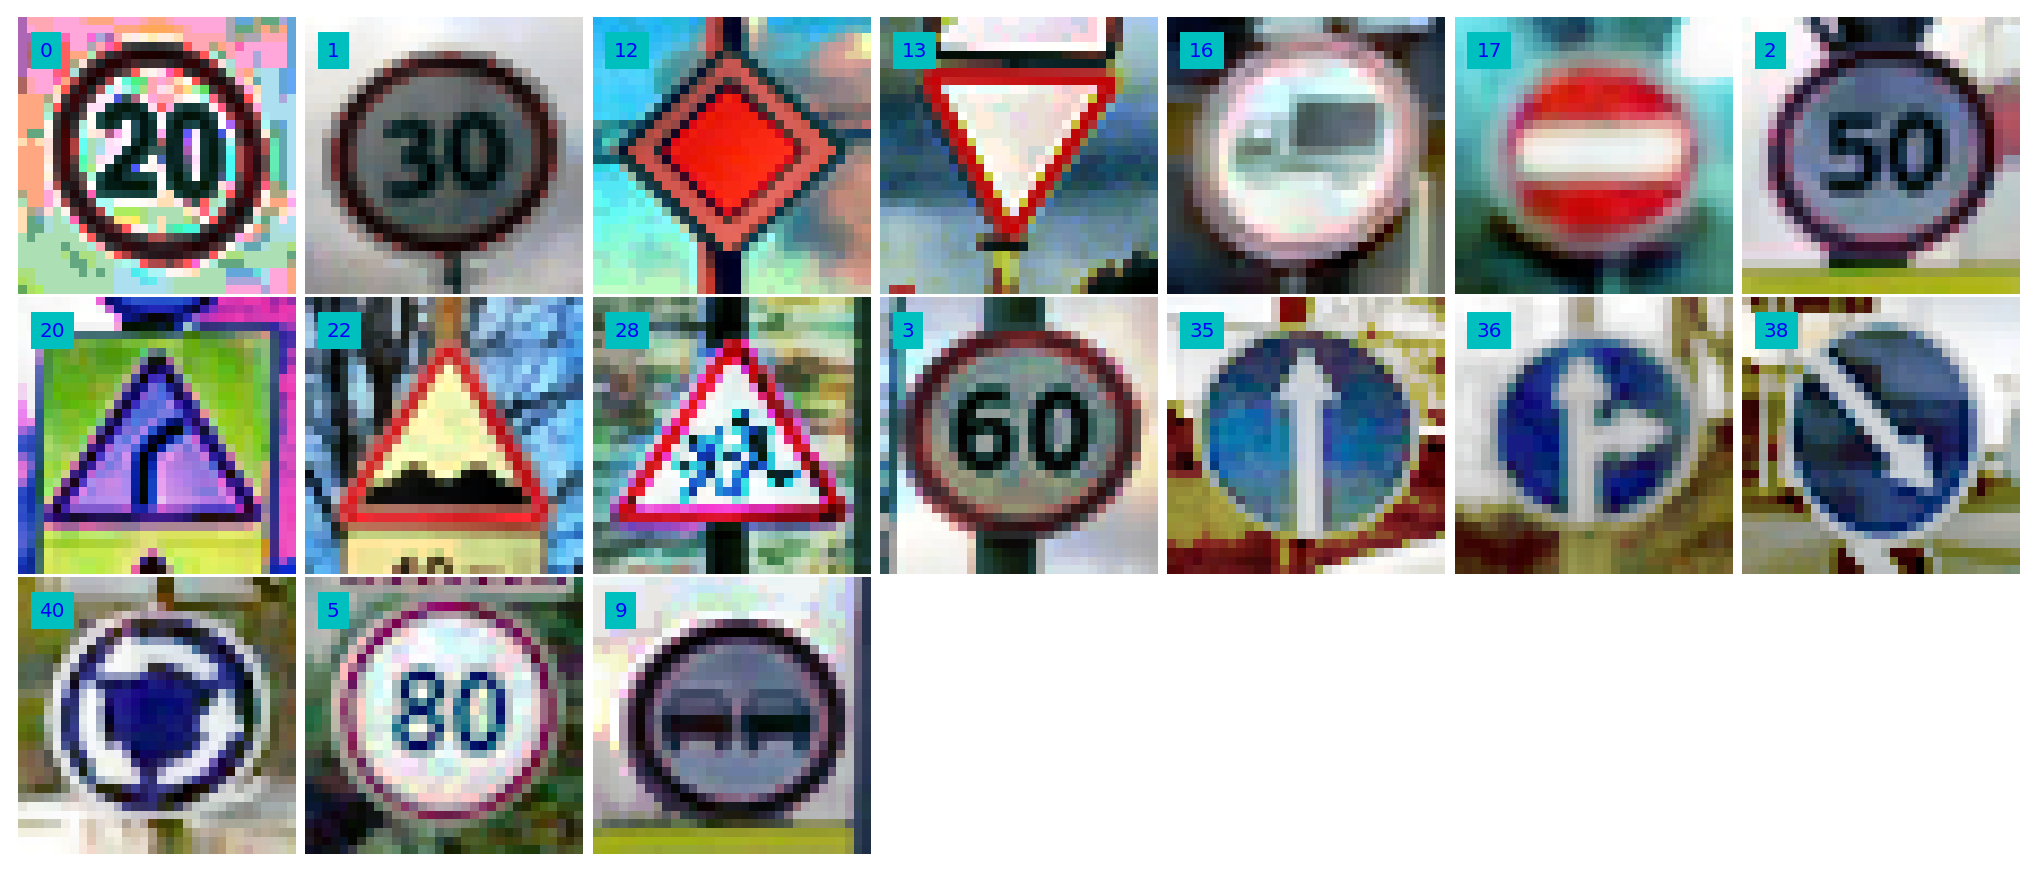

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
testing_samples_file = 'processed/x_new_hist_eq_0_1_2.p'
x_test, y_test = aux.load_data(testing_samples_file)

aux.plot_samples(7,3,x_test, y_test, randomize=False)

### Predict the Sign Type for Each Image

In [19]:
print('loading test data..')
with open(testing_samples_file, mode='rb') as f:
    test = pickle.load(f)

X_test, y_test = test[0], test[1]

print('test data loaded')

save_file = './{}_0.ckpt'.format(model_name)
    
saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer()) #Lecture says no need to call this.
    saver.restore(sess, save_file)
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

loading test data..
test data loaded
Test Accuracy = 0.941


Testing Accuracy: 0.9411765336990356

Softmax predictions:


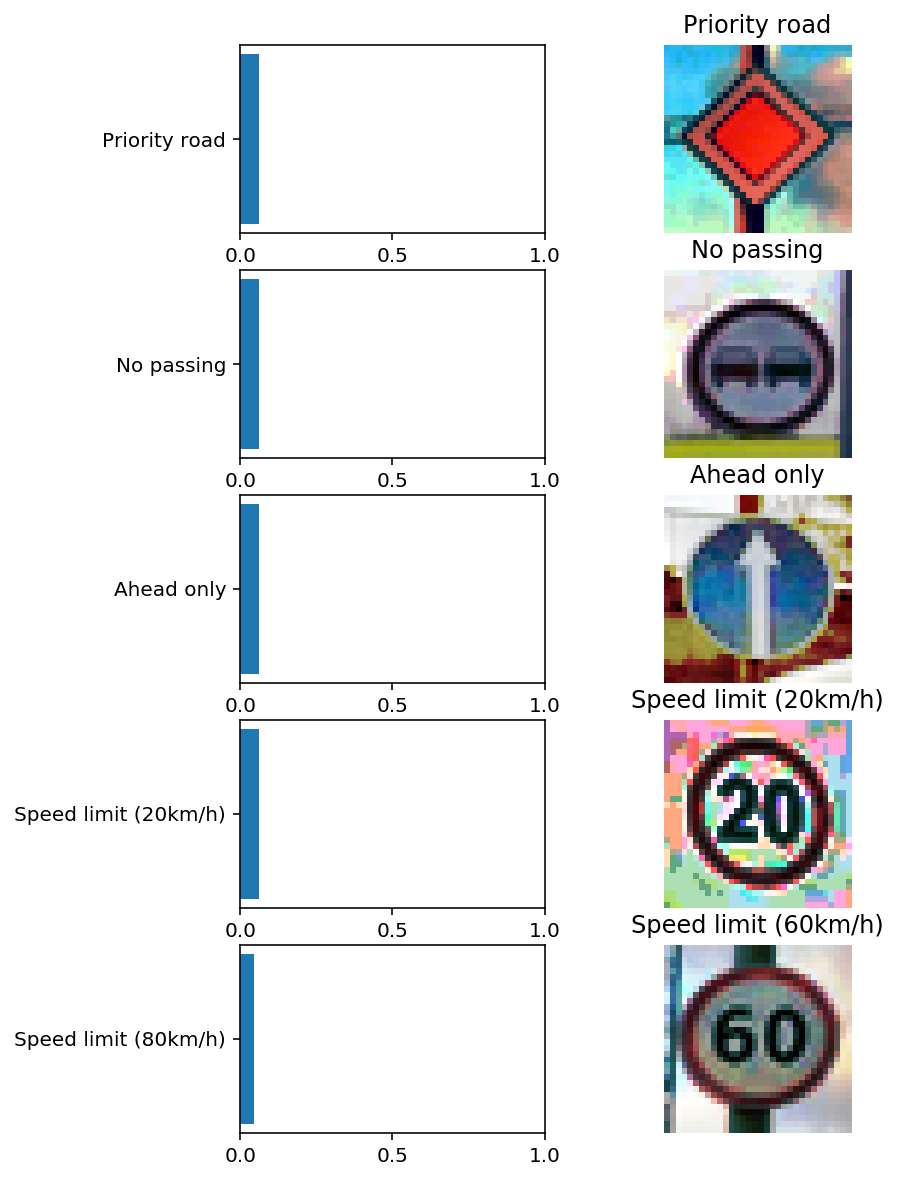

In [27]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
n_samples = 5
top_n_predictions = 1
legend_file = 'signnames.csv'

save_file = './{}_0.ckpt'.format(model_name)

layers = aux.test_model(test_data_file=testing_samples_file, 
                        model_file=save_file, 
                        tf_names=tf_names, 
                        batch_size=BATCH_SIZE, 
                        samples_to_test_count=n_samples, 
                        top_n=top_n_predictions, labels_legend_file=legend_file)


### Analyze Performance

Test accuracy on new images is 94,1%, which is a bit lower though still rather high. This may be due to the fact that the network has been trained on German signs while Lithuanian are a little bit different, though similar. For axample, 'Speed limit 60' has been predicted as 'Speed limit 80' due to the fact that digit '6' in German signs looks quite different.


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

Testing Accuracy: 0.9411765336990356

Softmax predictions:


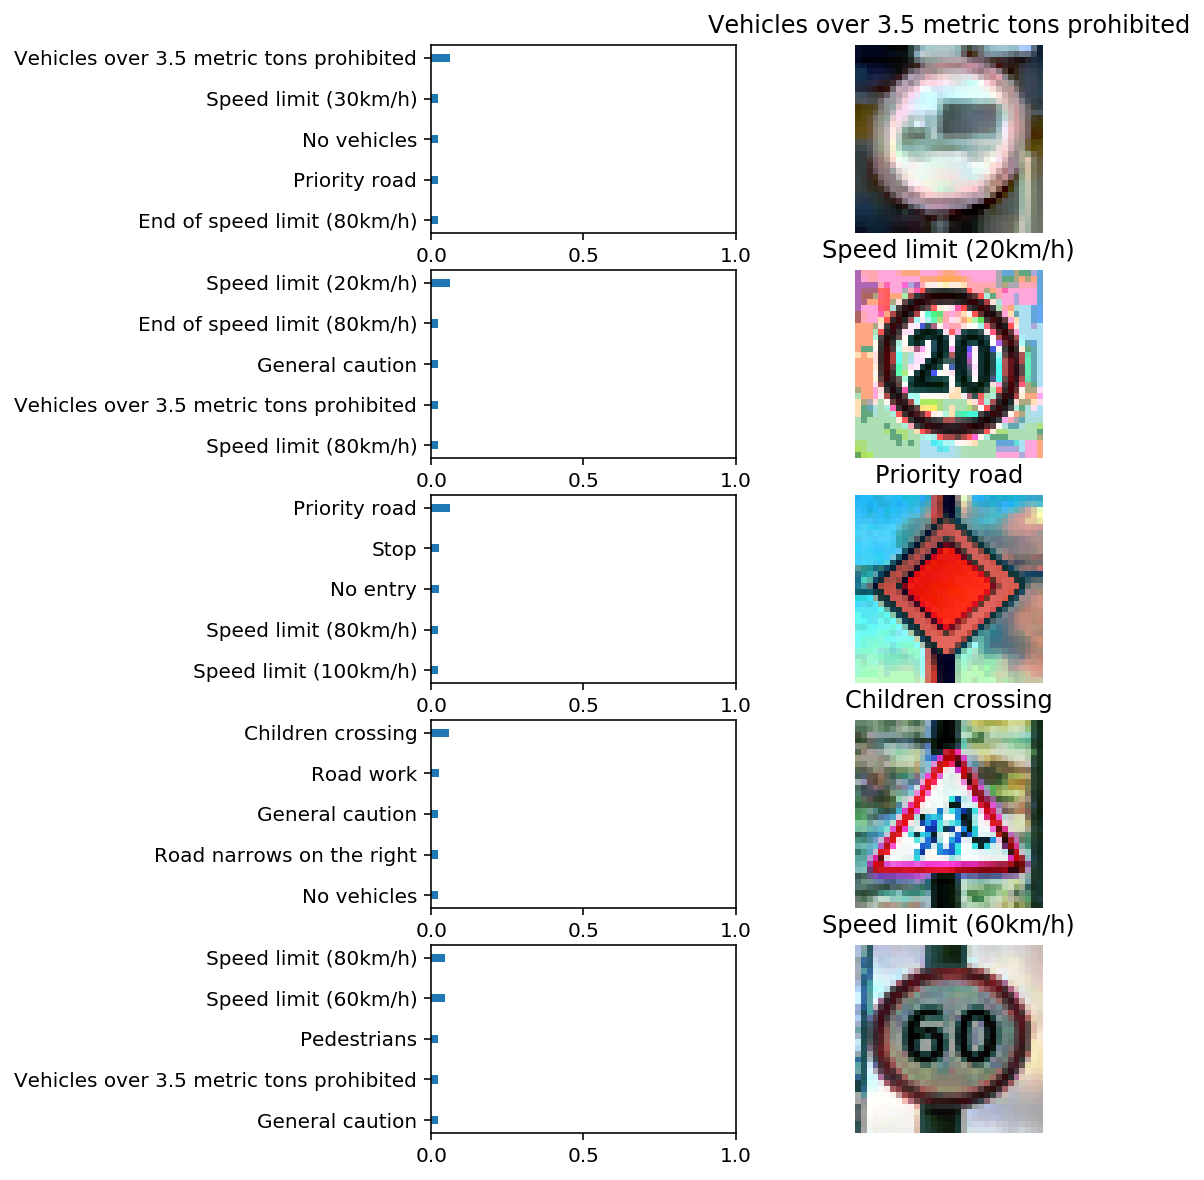

In [31]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
layers = aux.test_model(test_data_file=testing_samples_file, 
                        model_file=save_file, 
                        tf_names=tf_names, 
                        batch_size=BATCH_SIZE, 
                        samples_to_test_count=n_samples, 
                        top_n=5, labels_legend_file=legend_file)

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [32]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        plt.axis('off')
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max)#, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max)#, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min)#, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest")#, cmap="gray")

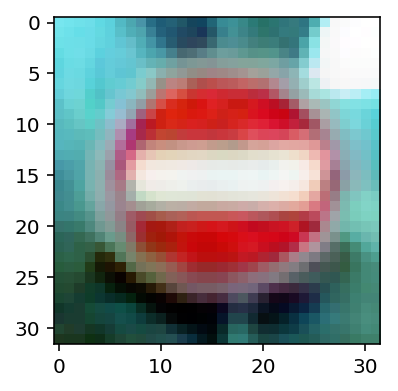

In [48]:
idx = 5
img = x_test[idx]
plt.figure(figsize=(3,3))
plt.imshow(x_test[idx])

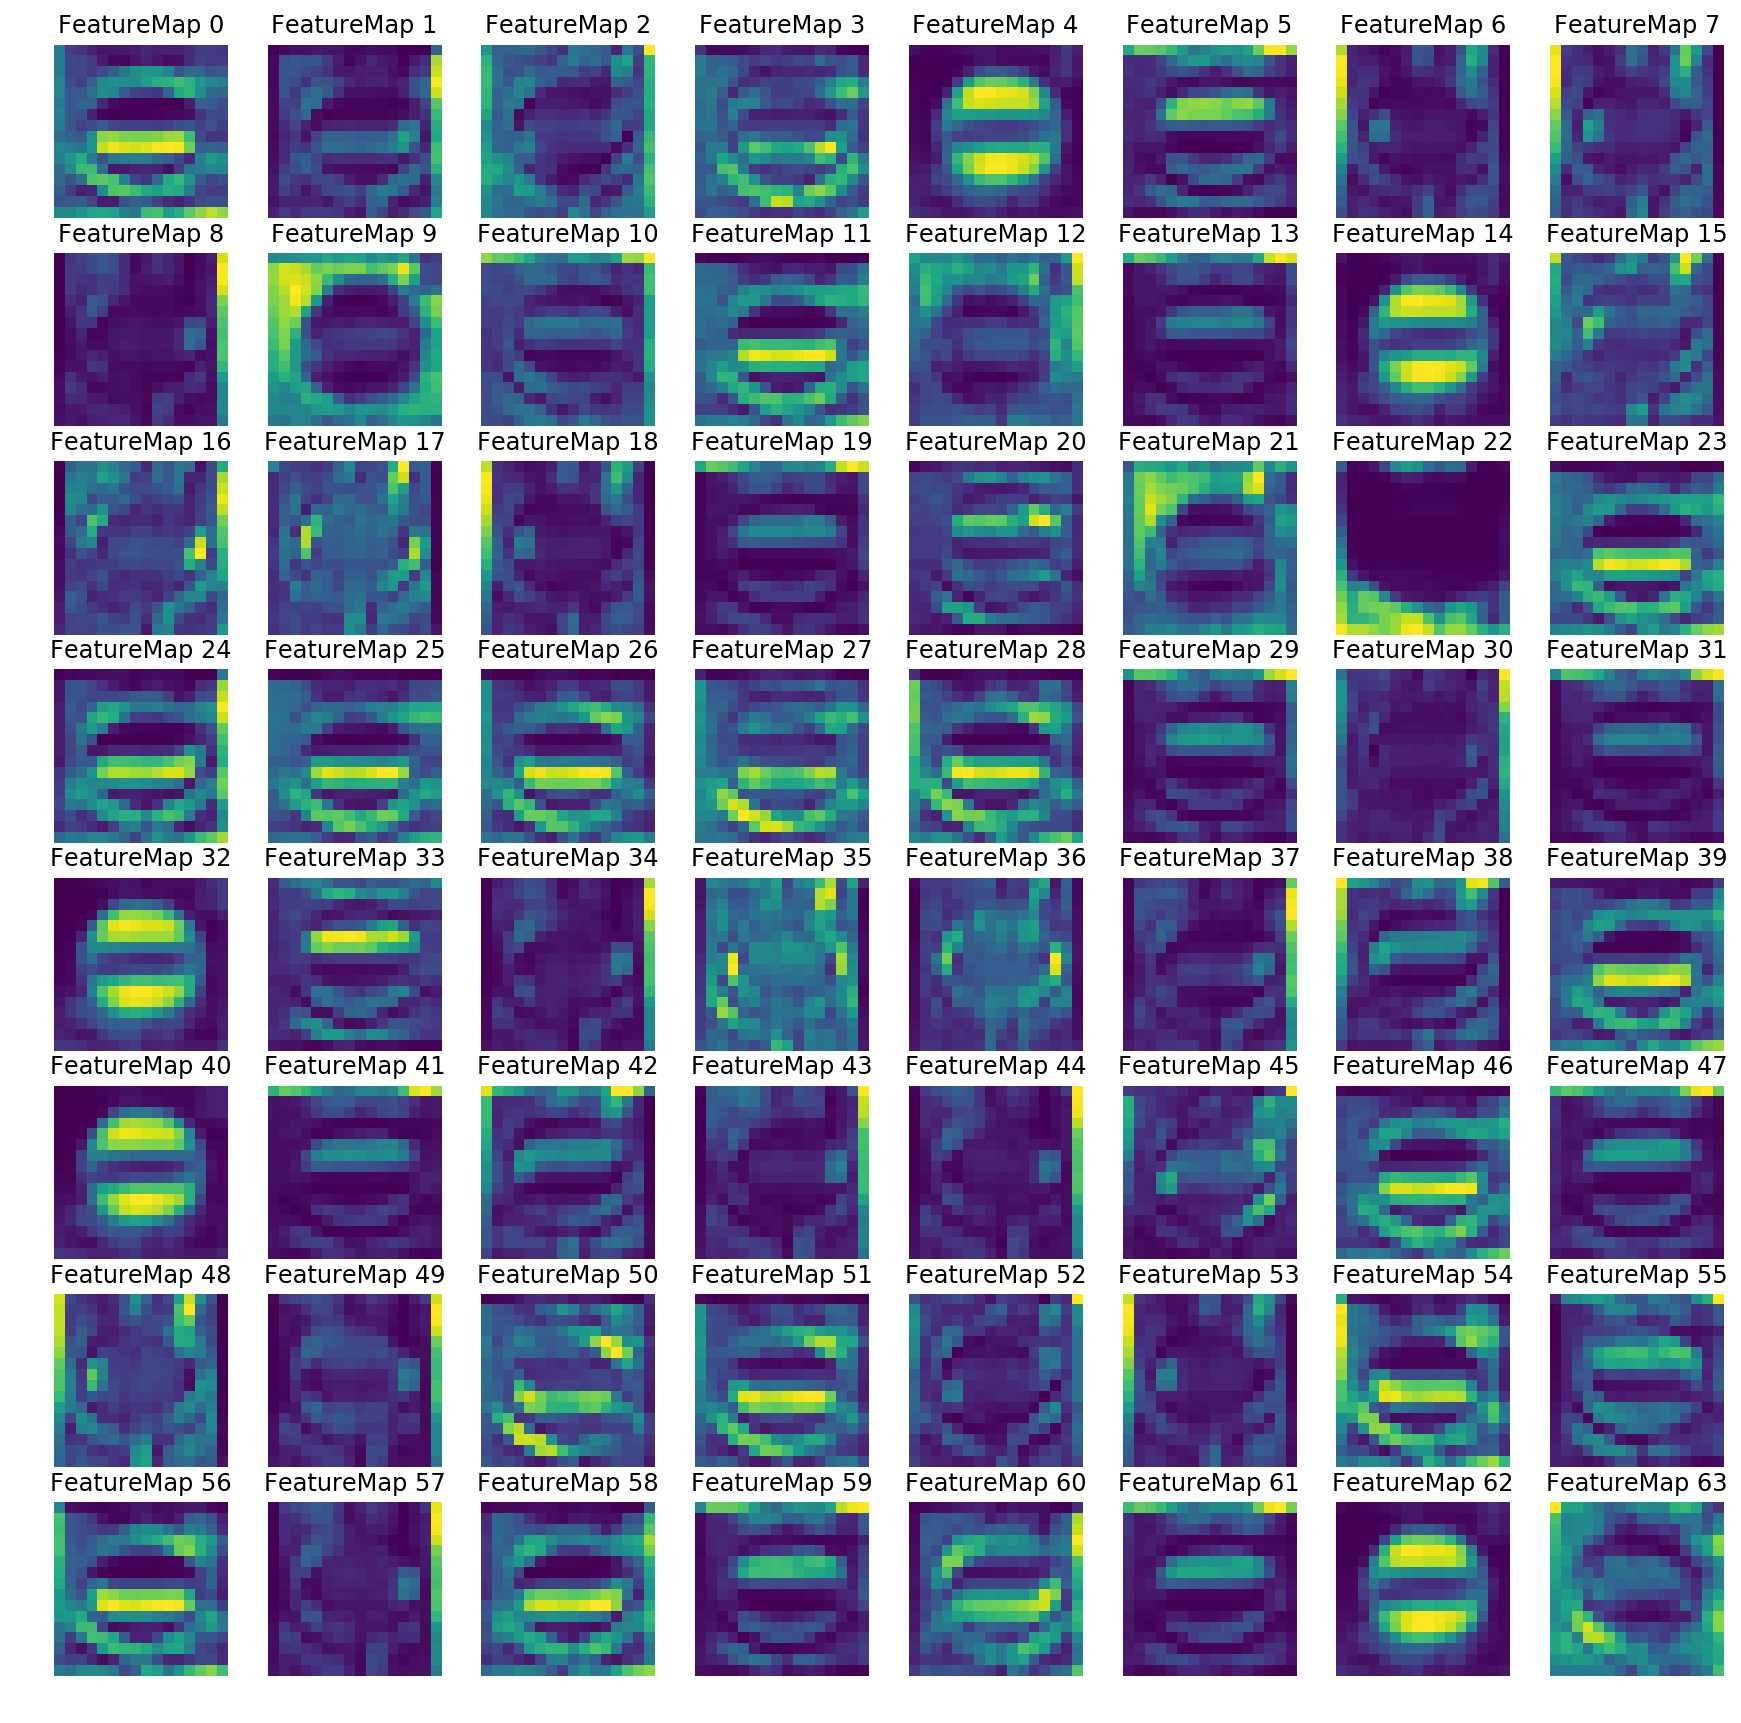

In [50]:
l_names = ['dropout/mul:0', 
           'dropout_1/mul:0',
           'dropout_2/mul:0',
           'dropout_3/mul:0',
           'dropout_4/mul:0',]



with tf.Session() as sess:
    saver.restore(sess, save_file)
    layer = sess.graph.get_tensor_by_name(l_names[0])
    outputFeatureMap(image_input=[x_test[idx]], tf_activation=layer)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

Network obviously captured shapes, colors and spacial location of the features.
For example, feature maps 4, 14, 32, 40 and 62 are excited about red color, while 22 captures low value pixels. It reacts violently to both black and dark blue at the center.
Activation on 'Priority road' exposes that feature maps are probably more sensitive to negative slope (`\`) lines rather than positive ones.
Feature maps 9 and 21 seems to be responsible for blue color.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 